# RNN, LSTM, GRU의 주가 예측 모델의 성능 비교 테스트

In [49]:
import pandas as pd

df = pd.read_csv("../dataset/AAPL_2006-01-01_to_2018-01-01.csv")

df.head(5)

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [50]:
sample_x = df["Close"]
sample_y = df["Date"]

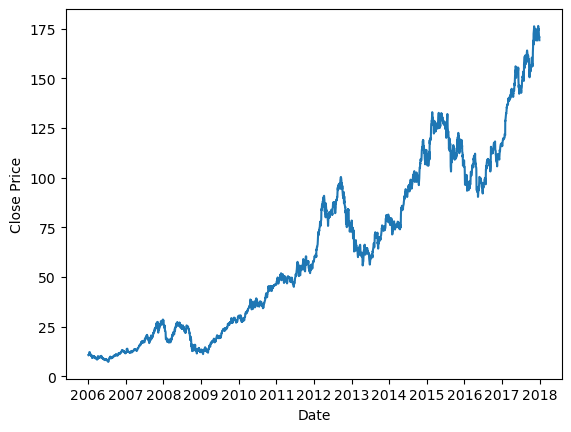

In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from datetime import datetime

date = []

for row in sample_y:
    date.append(matplotlib.dates.date2num(datetime.strptime(row, '%Y-%m-%d')))

plt.plot(date, sample_x.to_numpy())
plt.xlabel("Date")
plt.ylabel("Close Price")

ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
plt.show()

In [52]:
def show_stock_graph(prices):
    plt.plot(date, prices)
    plt.xlabel("Date")
    plt.ylabel("Close Price")

    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    plt.show()

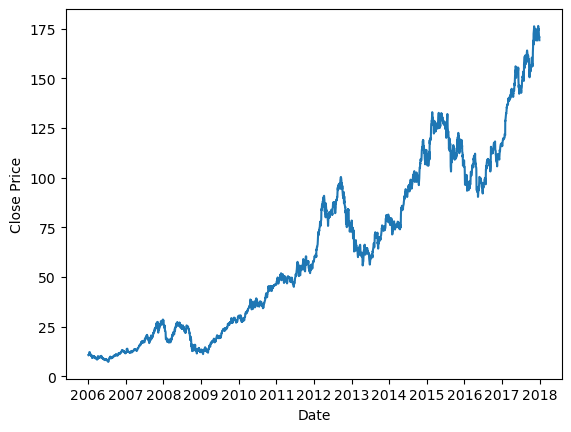

In [53]:
show_stock_graph(sample_x.to_numpy())

## 1. 종가만 가지고 예측을 진행하기

In [54]:
import numpy as np

def split_data(stock, lookback):
    data_row = stock.to_numpy()
    data = []

    for index in range(len(data_row) - lookback):
        data.append(data_row[index:index+lookback])
    
    data = np.array(data)

    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train = data[:train_set_size, :-1]
    y_train = data[:train_set_size, -1]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1]

    return [x_train, y_train, x_test, y_test]


In [55]:
lookback = 20
price = df["Close"]
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [56]:
x_train[:3], y_train[:3]

(array([[10.68, 10.71, 10.63, 10.9 , 10.86, 11.55, 11.99, 12.04, 12.23,
         12.1 , 11.78, 11.29, 10.87, 11.1 , 10.86, 10.6 , 10.33, 10.29,
         10.71],
        [10.71, 10.63, 10.9 , 10.86, 11.55, 11.99, 12.04, 12.23, 12.1 ,
         11.78, 11.29, 10.87, 11.1 , 10.86, 10.6 , 10.33, 10.29, 10.71,
         10.79],
        [10.63, 10.9 , 10.86, 11.55, 11.99, 12.04, 12.23, 12.1 , 11.78,
         11.29, 10.87, 11.1 , 10.86, 10.6 , 10.33, 10.29, 10.71, 10.79,
         10.77]]),
 array([10.79, 10.77, 10.3 ]))

In [57]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [105]:
input_dim = 1
hidden_dim = 19
num_layers = 2
output_dim = 1
num_epochs = 300

In [112]:
from torchsummary import summary as summary_

class RNN_v1(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN_v1, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 300)
        self.batchnorm = nn.BatchNorm1d(300)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(300, output_dim)

    def forward(self, x):
        out, state_ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


model = RNN_v1(input_dim, hidden_dim, num_layers, output_dim)
summary_(model,(19,1),batch_size=10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 19, 19], [-1, 2, 19]]               0
            Linear-2                  [10, 300]           6,000
       BatchNorm1d-3                  [10, 300]             600
              ReLU-4                  [10, 300]               0
           Dropout-5                  [10, 300]               0
            Linear-6                    [10, 1]             301
Total params: 6,901
Trainable params: 6,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 0.03
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


In [131]:
from torchsummary import summary as summary_

class RNN_v2(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN_v2, self).__init__()
        self.rnn1 = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.rnn2 = nn.RNN(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 300)
        self.batchnorm = nn.BatchNorm1d(300)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(300, output_dim)

    def forward(self, x):
        out, state_ = self.rnn1(x)
        out, state_ = self.rnn2(out)
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


model = RNN_v2(input_dim, hidden_dim, num_layers, output_dim)
summary_(model,(19,1),batch_size=10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 19, 19], [-1, 2, 19]]               0
               RNN-2  [[-1, 19, 19], [-1, 2, 19]]               0
            Linear-3                  [10, 300]           6,000
       BatchNorm1d-4                  [10, 300]             600
              ReLU-5                  [10, 300]               0
           Dropout-6                  [10, 300]               0
            Linear-7                    [10, 1]             301
Total params: 6,901
Trainable params: 6,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 0.03
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


In [113]:
import torch.optim as optim

#model = RNN(input_dim, 30, output_dim, num_layers)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [114]:
# x_train = x_train.squeeze(0)
# print(x_train.shape)
x_train_rnn = x_train.unsqueeze(2)
print(x_train_rnn.shape)

y_train_rnn_ = y_train_rnn.unsqueeze(1)
print(y_train_rnn_.shape)


torch.Size([2399, 19, 1])
torch.Size([2399, 1])


In [132]:
import matplotlib.gridspec as gridspec

hist = []

for epoch in range(num_epochs):
    y_train_pred = model(x_train_rnn)

    optimizer.zero_grad()
    loss = criterion(y_train_pred, y_train_rnn_)
    print(f"Epoch: [{epoch}/{num_epochs}] | Loss: {loss.item()}")
    
    hist.append(loss.item())

    loss.backward()
    optimizer.step()


Epoch: [0/1000] | Loss: 3655.921630859375
Epoch: [1/1000] | Loss: 3657.2080078125
Epoch: [2/1000] | Loss: 3655.96923828125
Epoch: [3/1000] | Loss: 3657.101806640625
Epoch: [4/1000] | Loss: 3654.33349609375
Epoch: [5/1000] | Loss: 3655.82666015625
Epoch: [6/1000] | Loss: 3655.21875
Epoch: [7/1000] | Loss: 3656.44091796875
Epoch: [8/1000] | Loss: 3655.952392578125
Epoch: [9/1000] | Loss: 3655.685791015625
Epoch: [10/1000] | Loss: 3656.82275390625
Epoch: [11/1000] | Loss: 3657.30224609375
Epoch: [12/1000] | Loss: 3656.400634765625
Epoch: [13/1000] | Loss: 3655.97998046875
Epoch: [14/1000] | Loss: 3656.11474609375
Epoch: [15/1000] | Loss: 3653.90673828125
Epoch: [16/1000] | Loss: 3656.542724609375
Epoch: [17/1000] | Loss: 3655.4443359375
Epoch: [18/1000] | Loss: 3656.48388671875
Epoch: [19/1000] | Loss: 3654.907470703125
Epoch: [20/1000] | Loss: 3656.879638671875
Epoch: [21/1000] | Loss: 3655.076171875
Epoch: [22/1000] | Loss: 3655.71435546875
Epoch: [23/1000] | Loss: 3654.74853515625
Epoc

In [110]:
def show_history(hist, y, y_pred):
    fig = plt.figure() 

    gs = gridspec.GridSpec(1, 2)

    ax1 = plt.subplot(gs[0,0])
    ax1.plot(y)
    ax1.plot(y_pred)
    ax1.legend()

    # ax1.xlabel("Date")
    # ax1.ylabel("Price") 

    #x_range = np.arange(hist.shape[0])
    ax2 = plt.subplot(gs[0, 1])
    ax2.plot(range(len(hist)), hist)
    # ax2.xlabel("Epoch")
    # ax2.ylabel("Training Loss")

    plt.show()



- 1차 테스트:실패 -> 모델 선언 변수를 오해...
- 2차 테스트: 성공 -> 하지만 너무 높은 손실
- 3차 테스트: 성공 -> 다양한 방법을 도입해서 신경망의 손실을 몇백대까지 올림...
- 4차 테스트: 성공 -> FC 레이어의 결합 개수를 대폭 상향 결과 손실 값의 비약적인 하락을 볼 수 있었다. (model_v1)
- 5차 테스트: 실패 -> RNN 레이어를 깊게 쌓는다고 나아지지는 않는다..

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor([[  3.9792],
        [  4.2855],
        [  4.0034],
        ...,
        [107.3917],
        [ 90.3984],
        [119.8221]], grad_fn=<AddmmBackward0>)


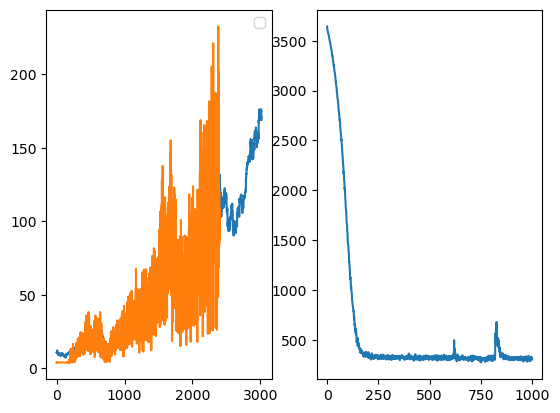

In [111]:
### 3차 테스트
y_finally_pred = model(x_train_rnn)

print(y_finally_pred)

show_history(hist, price.to_numpy(), y_finally_pred.detach().numpy())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


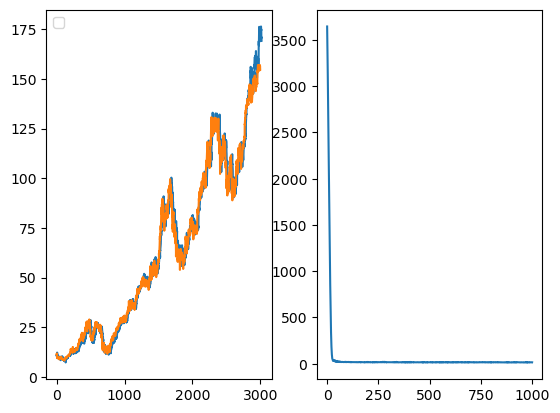

In [127]:
### 4차 테스트
model.eval()
with torch.no_grad():
    y_test_rnn_ = x_test.unsqueeze(2)
    y_finally_pred1 = model(x_train_rnn)
    y_finally_pred2 = model(y_test_rnn_)
    y = np.concatenate([y_finally_pred1, y_finally_pred2])

show_history(hist, price.to_numpy(), y)

In [133]:
from sklearn.preprocessing import MinMaxScaler

In [134]:
df = pd.read_csv("../dataset/AAPL_2006-01-01_to_2018-01-01.csv")

time_seqs = 7
batch = 100

train_size = int(len(df)*0.7)
test_size = len(df)-train_size 

print(f"Train Size: {train_size}, Test Size: {test_size}")

Train Size: 2113, Test Size: 906


In [189]:
train_set = df[:train_size]
test_set = df[train_size-time_seqs:]

train_set = train_set.iloc[:, 1:-1]
test_set = test_set.iloc[:, 1:-1]

print(train_set.head(8))

    Open   High    Low  Close     Volume
0  10.34  10.68  10.32  10.68  201853036
1  10.73  10.85  10.64  10.71  155225609
2  10.69  10.70  10.54  10.63  112396081
3  10.75  10.96  10.65  10.90  176139334
4  10.96  11.03  10.82  10.86  168861224
5  10.89  11.70  10.83  11.55  570088246
6  11.98  12.11  11.80  11.99  373548882
7  12.14  12.34  11.95  12.04  320201966


In [194]:
from torch.utils.data import TensorDataset, DataLoader 

def build_dataset(time_series, seq_length):
    data = []
    for i in range(0, len(time_series)-seq_length-1):
        data.append(time_series.iloc[i:i+seq_length+1, :])
        # _x = time_series.iloc[i:i+seq_length, 1:-1]
        # _y = time_series[i+seq_length, [-2]]
    
    data = np.array(data, dtype=np.float64)
    data_x = data[:, :-1, :]
    data_y = data[:, -1, -2]
    return data_x,data_y

train_x, train_y = build_dataset(train_set,time_seqs)
test_x, test_y = build_dataset(test_set, time_seqs)


train_x = torch.from_numpy(train_x).type(torch.Tensor)
train_y = torch.from_numpy(train_y).type(torch.Tensor).unsqueeze(1)


test_x = torch.from_numpy(test_x).type(torch.Tensor)
test_y = torch.from_numpy(test_y).type(torch.Tensor).unsqueeze(1)

dataset = TensorDataset(train_x, train_y)

dataloader = DataLoader(dataset, batch_size=batch, shuffle=True, drop_last=True)

In [195]:
x, y=next(iter(dataloader))
x.shape, y.shape

(torch.Size([100, 7, 5]), torch.Size([100, 1]))

In [209]:
x1 = torch.tensor([[[1], [2],[3]]])
x2 = torch.tensor([[[6], [3],[4]]])
torch.concat([x1, x2], dim=2)

tensor([[[1, 6],
         [2, 3],
         [3, 4]]])

In [247]:
input_dim = 5
hidden_dim = 30
output_dim = 1
learning_rate = 0.01
nb_epochs = 100

class LSTM_v1(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.num_layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.num_layers, self.seq_len, self.hidden_dim)
        )

    def forward(self, x):
        x, _status = self.lstm(x)
        x = x[:, -1]
        x = self.fc(x)
        return x

class LSTM_v2(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim-1, hidden_dim, num_layers=num_layers, batch_first=True)
        self.embedding = nn.Embedding(7,7)

        self.fc = nn.Linear(hidden_dim, 100)
        self.batchnorm = nn.BatchNorm1d(100)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, output_dim)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.num_layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.num_layers, self.seq_len, self.hidden_dim)
        )

    def forward(self, x):
        x1, x2 = x[:, :,:-1], x[:, :, -1]
        
        x_, _status = self.lstm(x1)
        x2 = x2.unsqueeze(2).type(torch.LongTensor)
        print(x1.shape, x2.shape)
        x__ = self.embedding(x2)
        print("aaa")
        x_ = x_[:, -1]
        x = torch.concat([x_, x__], dim=2)
        print(x.shape)
        out = self.fc(x)
        out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return x



In [248]:
def train_lstm(model, train_df, num_epochs, lr, verbose=10, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    nb_epochs = num_epochs 

    train_hist = np.zeros(nb_epochs)

    model.train()

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)

        for batch_idx, samples in enumerate(train_df):
            x_train, y_train = samples 
            x_train, y_train = x_train.to(device), y_train.to(device)

            model.reset_hidden_state()

            outputs = model(x_train)

            loss = criterion(outputs, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost += loss/total_batch

        train_hist[epoch] = avg_cost 

        if epoch % verbose == 0:
            print(f"Epoch: [{epoch+1}/{nb_epochs}] | Train Loss: {avg_cost:.4f}")

        if (epoch % patience == 0) and (epoch != 0):
            # Early Stopping to Prevent Overfitting
            if train_hist[epoch-patience] < train_hist[epoch]:
                break 

    return model.eval(), train_hist

In [249]:
net = LSTM_v1(input_dim, hidden_dim, time_seqs, output_dim, 1)
model, train_hist = train_lstm(net, dataloader, nb_epochs, learning_rate, 20, 10)

Epoch: [1/100] | Train Loss: 2261.5667
Epoch: [21/100] | Train Loss: 792.0062
Epoch: [41/100] | Train Loss: 674.2039
Epoch: [61/100] | Train Loss: 671.3096


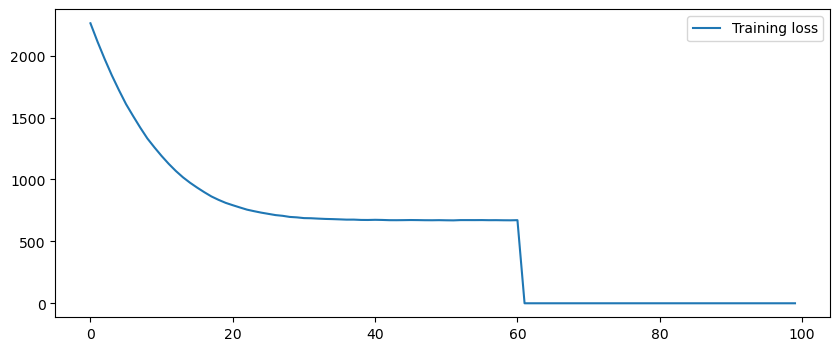

In [250]:
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [251]:
# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(test_x)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(test_x[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)


def MAE(true, pred):
    return np.mean(np.abs(true-pred))

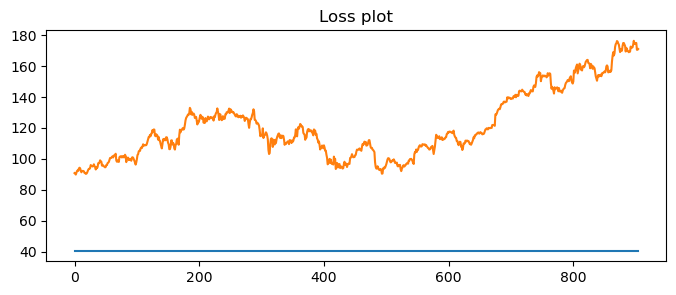

In [252]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred)), pred, label = 'pred')
plt.plot(np.arange(len(test_y)), test_y, label = 'true')
plt.title("Loss plot")
plt.show()